# HM Land Registry Open Data
<details><summary>Data Analysis Problem:</summary>
<br>
Please download data from HM Land Registry Open Data, profile and clean the data and run some analyses, I am happy for you to use any language you prefer, but please submit both your code sample and your output. I am looking for these skills:
<pre>
1. Your ability to take a completely new dataset and make it ready for analysis (Data Engineering);
2. Defining questions you can answer from the data (Data Analysis);
3. Analyses and conclusions (Data Analysis)
</pre>
</details>


## Data Sources
[Land registry information](https://landregistry.data.gov.uk) used in this report is made available under the [Open Government License v3.0 (OGLv3.0)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)   
[Shape data for the uk](https://geoportal.statistics.gov.uk/datasets/counties-and-unitary-authorities-december-2020-uk-bfc?geometry=-44.292%2C51.101%2C39.424%2C59.782) licensed under a [custom licence](https://www.ons.gov.uk/methodology/geography/licences) by Ordnance Survey and ONS  
[Population data](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland) available under [Open Government License v3.0 (OGLv3.0)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)   


## Import libraries

In [1]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.dates import DateFormatter


## constant values

In [2]:
root_dir = os.path.abspath('.')

# Process transaction data into one file
## Rename archived files
rename raw datasets of transaction data .csv and save elsewhere. A few files were processed by hand due to not fitting with the internal structure or not having any meta data.

---

Move working directory

In [3]:
os.chdir(root_dir)
os.chdir("../RawData/TransactionData")

In [4]:
all_files = os.listdir()
write_protect = True
# Make sure code isn't accidentally run
if write_protect == False:
    for ifile in all_files:
        if ifile[-4:] == ".csv":
            with open(ifile) as file_open:
                file_open = open(ifile)
                file_read = file_open.read()
                name_loc = file_read.find(",")
            
                if file_read[0][0] == "\ufeff":
                    file_name = file_read[1:name_loc]
                    name_loc -= 1
                else:
                    file_name = file_read[:name_loc]


                if file_name == "Land Registry":
                    with open(ifile) as temp_read:
                        file_read = ''.join(temp_read.readlines()[2:])
                        name_loc = file_read.find(",")
                        file_name = file_read[:name_loc]

            if file_name.replace(' ','-')+'-' == ifile[:name_loc+1]:
                file_name = ifile
            else:
                month_start = file_read.find("Calendar Month,")+15
                month_end = file_read.find(',',month_start)
                date_name = file_read[month_start:month_end].split()
                if len(date_name) == 1:
                    date_name = date_name[0].split('-')
                    month_num = datetime.datetime.strptime(date_name[0],"%b").month+1
                else:
                    month_num = datetime.datetime.strptime(date_name[0],"%B").month+1
                
                if month_num == 13:
                    month_num = 1
                    date_name[1] = str(int(date_name[1])+1)

                file_name += " " + date_name[1] + " " + str(month_num).zfill(2) + ".csv"
                file_name = file_name.replace(' ','-')
            
            file_open.close()
            # Copy data to midpoint folder (TransactionDataRenamed) before concatination
            with  open("../TransactionDataRenamed/" + file_name, 'w') as new_file:
                new_file.write(file_read)
                new_file.close()

## Data Concatination
First check for missing files

In [5]:
os.chdir(root_dir)
os.chdir("../RawData/TransactionDataRenamed")

In [6]:
renamed_files = os.listdir()
renamed_files.sort()
unique_files = list(set([i[:-11] for i in renamed_files]))
log_missing = []

for file_type in unique_files:
    for year in range(2012,2022):
        for month in range(1,13):
            if year == 2021 and month > 4:
                break
            file_search = file_type+str(year)+'-'+str(month).zfill(2)+'.csv'
            if file_search in renamed_files:
                pass
            else:
                log_missing.append(file_search)
log_missing

['Number-and-types-of-transactions-for-value-by-all-account-customers-2014-07.csv',
 'Number-of-searches-by-all-account-customers-2014-07.csv',
 'Number-of-applications-in-England-and-Wales-divided-by-local-authority-2014-07.csv',
 'Number-and-types-of-applications-by-all-account-customers-2014-07.csv',
 'Number-of-applications-in-England-and-Wales-divided-by-region-2014-07.csv']

log_missing confirms only 2014-07 .csv files are missing, which appear to be a black spot in the data from switching between archive and current.  

---
Now concatinate all files together into one transaction file.

In [7]:
a = []
dict_df = {i:[] for i in unique_files}
for ifile in renamed_files:
    tmp_df = pd.read_csv(ifile,
                    skiprows=4,
                    index_col=0)
    tmp_df['Date'] = ifile[-11:-4]
    dict_df[ifile[:-11]].append(tmp_df)

for ikey in dict_df.keys():
    dict_df[ikey] = pd.concat(dict_df[ikey])
    dict_df[ikey].to_csv("../CleanTransaction/"+ikey[:-1]+".csv")

## Data cleaning  
Make the other remaining .csv ready for analysis. No post processing has been done due to the data being very thorough, with changes only made with how pandas reads in the csv by default (especially in the case of the price paid (pp) data which needs a large amount of columns culled before it can be read).

In [8]:
os.chdir(root_dir)
os.chdir('..')

In [9]:
pp_columns = ['Transaction unique identifier',
              'Price',
              'Date of Transfer',
              'Postcode',
              'Property Type',
              'Old/New',
              'Duration',
              'PAON',
              'SAON',
              'Street',
              'Locality',
              'Town/City',
              'District',
              'County',
              'PPD Category Type',
              'Record Status-monthly file only']
indexs = [1,2,4,5,6,13]#[3,7,2,1,5,6]
pp_col_slice = [pp_columns[i] for i in indexs]
pp = pd.read_csv('RawData/PricePaidData/pp-complete.csv',
                 names=pp_col_slice,
                 usecols=indexs,
                 index_col=[5,1],#[2,13,12,11,10,9,8,7,3,0],
                 engine='c',
                 )

In [10]:
pp.head()

,,Price,Property Type,Old/New,Duration
County,Date of Transfer,,,,
TYNE AND WEAR,1995-12-21 00:00,42000,S,N,F
THURROCK,1995-03-03 00:00,95000,S,N,F
CHESHIRE,1995-10-03 00:00,74950,D,Y,F
STOCKTON-ON-TEES,1995-11-14 00:00,43500,S,N,F
CUMBRIA,1995-09-08 00:00,63000,S,N,F


In [11]:
hpi = pd.read_csv('RawData/HPI/UK-HPI-full-file-2021-02.csv',
                  index_col='RegionName')
columns = ['Date','AreaCode', 
           'AveragePrice', 'Index', 'IndexSA', '1m%Change', '12m%Change', 'AveragePriceSA', 'SalesVolume', 
           'DetachedPrice', 'DetachedIndex', 'Detached1m%Change', 'Detached12m%Change',
           'SemiDetachedPrice', 'SemiDetachedIndex', 'SemiDetached1m%Change', 'SemiDetached12m%Change', 
           'TerracedPrice', 'TerracedIndex', 'Terraced1m%Change', 'Terraced12m%Change', 
           'FlatPrice', 'FlatIndex', 'Flat1m%Change', 'Flat12m%Change', 
           'CashPrice', 'CashIndex', 'Cash1m%Change', 'Cash12m%Change', 'CashSalesVolume', 
           'MortgagePrice', 'MortgageIndex', 'Mortgage1m%Change', 'Mortgage12m%Change', 'MortgageSalesVolume', 
           'FTBPrice', 'FTBIndex', 'FTB1m%Change', 'FTB12m%Change', 
           'FOOPrice', 'FOOIndex', 'FOO1m%Change','FOO12m%Change', 
           'NewPrice', 'NewIndex', 'New1m%Change', 'New12m%Change', 'NewSalesVolume', 
           'OldPrice', 'OldIndex', 'Old1m%Change', 'Old12m%Change', 'OldSalesVolume']
countries = ('England','Scotland','Wales','Northern Ireland')
hpi['Date'] = pd.to_datetime(hpi['Date'],dayfirst=True)


In [12]:
population = pd.read_csv('RawData/Population Data/PopulationData.csv',
                         index_col='Name')
#population.head()

# Analyse data
Look at the distribution of the amount paid per house across the UK

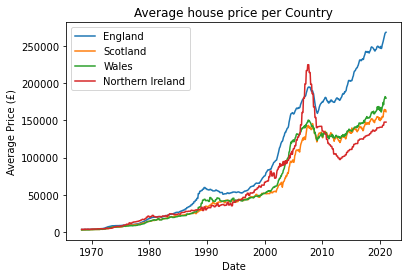

In [13]:
fig, ax = plt.subplots()

# x = pd.to_datetime(hpi.loc[counties[0]].index,dayfirst=True)
# x1 = pd.to_datetime([i[1] for i in hpi.index],dayfirst=True)
# y = hpi['AveragePrice']
mean_price = []
mean_start = []
for i in countries:
    # date_mask = hpi['Date'].loc[countries[i]] >= pd.to_datetime("01-01-2012",dayfirst=True)
    # x = hpi['Date'].loc[counties[i]][date_mask]
    ax.plot(hpi['Date'].loc[i],hpi['AveragePrice'].loc[i])

ax.legend(countries)
# ax.hist(mean_price,bins=50)
# ax.set_xlim(pd.to_datetime('2012'),pd.to_datetime('2021'))
# ax.set_xticks(pd.to_datetime(['2012','2014','2016','2018','2020']))
# ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_title('Average house price per Country')
ax.set_xlabel('Date')
ax.set_ylabel('Average Price (£)')
pass

Average price for housing in the UK has accelerated in England at a higher rate over the last 10 years in comparison to Northern Ireland, Scotland, and Wales.

England [379456.70406842104, 234352.78541842103, 202467.5263605263, 225878.4166842105]
Scotland [263394.69981315784, 159851.1011763158, 127513.36934473681, 109938.63749736841]
Wales [248478.94562105255, 159054.36898684205, 127623.7091394737, 115050.67838684212]
Northern Ireland [206817.4936447369, 134412.33678684203, 97624.81631263162, 109666.97302894741]


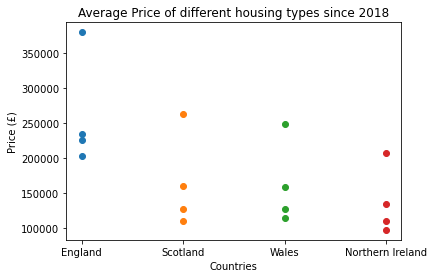

In [14]:

fig, ax = plt.subplots()

for i in countries:
    date_mask = hpi['Date'].loc[i] >= pd.to_datetime("01-01-2018",dayfirst=True)
    ax.scatter([i]*4,[hpi['DetachedPrice'].loc[i][date_mask].mean(),
                      hpi['SemiDetachedPrice'].loc[i][date_mask].mean(),
                      hpi['TerracedPrice'].loc[i][date_mask].mean(),
                      hpi['FlatPrice'].loc[i][date_mask].mean()
                      ])
    print(i,[hpi['DetachedPrice'].loc[i][date_mask].mean(),
                  hpi['SemiDetachedPrice'].loc[i][date_mask].mean(),
                  hpi['TerracedPrice'].loc[i][date_mask].mean(),
                  hpi['FlatPrice'].loc[i][date_mask].mean()])

ax.set_ylabel('Price (£)')
ax.set_xlabel('Countries')
ax.set_title('Average Price of different housing types since 2018')
pass

Detached homes are significantly more expensive, with most housing types in England costing close to double their counterparts in Scotland, Wales, and Northern Ireland.

In [15]:
#uk_map = gpd.read_file('ShapeData/Countries/Countries_(December_2020)_UK_BFC.shp',
                       index_col=['CTYUA20NM'])
#uk_map.plot()

IndentationError: unexpected indent (<ipython-input-15-919235cf0cb6>, line 2)